# Integração multimodal por representação (Mamografia + PGS)

## Contexto
Temos duas modalidades:
- **Imagem (mamografia)**: embeddings extraídos por CNN + compressão via autoencoder → espaço latente.
- **Genética (PGS/PRS)**: features tabulares + autoencoder → espaço latente.

Os conjuntos são de **cohorts diferentes**, então **não existe pareamento paciente↔paciente**.

## Objetivo agora
1) Caracterizar bem cada espaço latente (distribuição, estrutura, clusters, outliers).
2) Medir se existe **estrutura alinhável** entre os espaços (sem pareamento).
3) Demonstrar, com clareza, **o que seria possível** se tivéssemos dados pareados (mesmos pacientes):
   - CCA/Deep CCA por indivíduo
   - Retrieval cross-modal (imagem→genética e genética→imagem)
   - Concordância de risco / score
   - Modelos supervisionados com labels clínicos


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt


In [4]:
IMG_CSV = Path("./data/matrices/autoencoder_latent_space.csv")
GEN_CSV = Path("./data/matrices/genetic_latent_space.csv")

img_df = pd.read_csv(IMG_CSV)
gen_df = pd.read_csv(GEN_CSV)

print("img:", img_df.shape, img_df.columns.tolist())
print("gen:", gen_df.shape, gen_df.columns.tolist())


img: (149, 4) ['pgs_id', 'z1', 'z2', 'z3']
gen: (149, 4) ['pgs_id', 'z1', 'z2', 'z3']


In [5]:
def numeric_feature_cols(df, exclude=("join_id", "id", "patient_id", "series_uid")):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in num_cols if c not in set(exclude)]

img_cols = numeric_feature_cols(img_df)
gen_cols = numeric_feature_cols(gen_df)

print("img features:", img_cols)
print("gen features:", gen_cols)


img features: ['z1', 'z2', 'z3']
gen features: ['z1', 'z2', 'z3']


In [6]:
X_img_raw = img_df[img_cols].values
X_gen_raw = gen_df[gen_cols].values

sc_img = StandardScaler()
sc_gen = StandardScaler()

X_img = sc_img.fit_transform(X_img_raw)
X_gen = sc_gen.fit_transform(X_gen_raw)

print(X_img.shape, X_gen.shape)


(149, 3) (149, 3)


## A. Diagnóstico do espaço latente

Primeiro vamos entender cada espaço:
- Distribuição por dimensão (z)
- Correlações internas
- Estrutura (PCA 2D)
- Clusters (KMeans + Silhouette)
- Outliers (norma, distância aos centros)


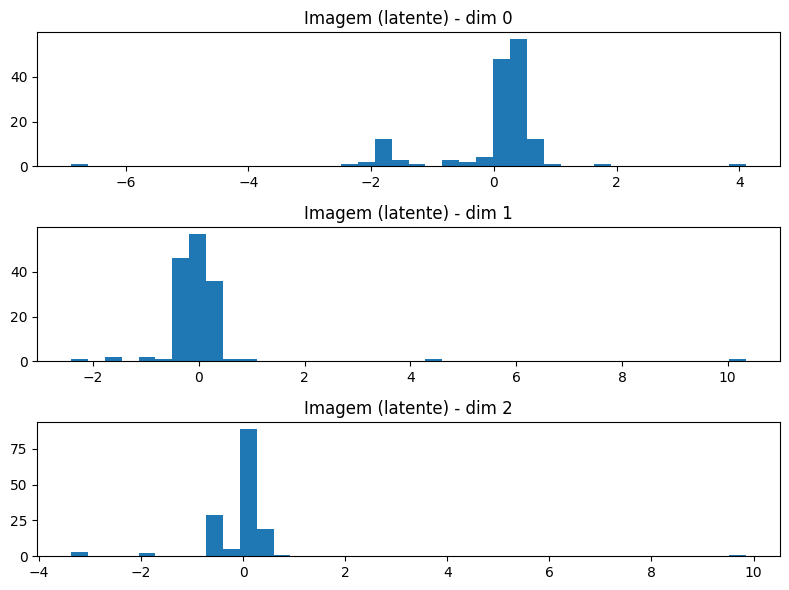

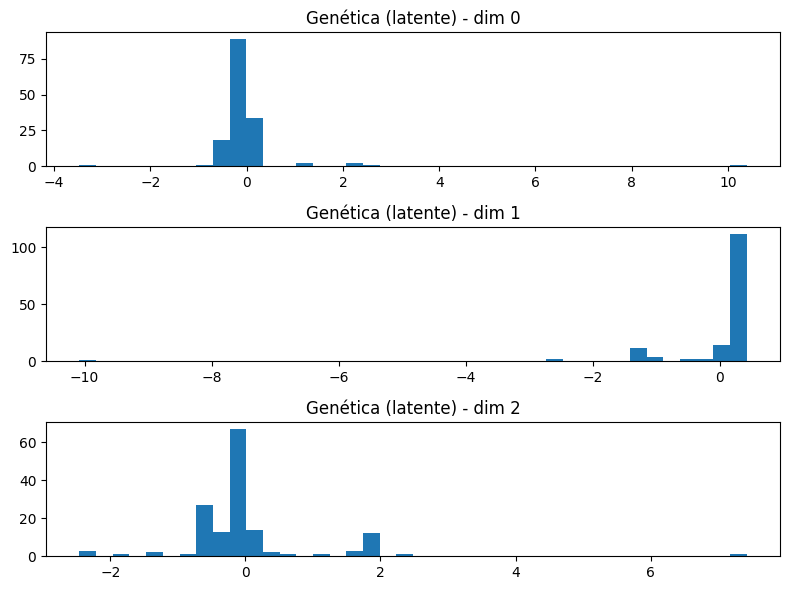

In [8]:
def plot_hist_per_dim(X, title_prefix, max_dims=12, bins=40):
    d = X.shape[1]
    m = min(d, max_dims)
    fig, axes = plt.subplots(m, 1, figsize=(8, 2*m))
    if m == 1:
        axes = [axes]
    for i in range(m):
        axes[i].hist(X[:, i], bins=bins)
        axes[i].set_title(f"{title_prefix} - dim {i}")
    plt.tight_layout()
    plt.show()

plot_hist_per_dim(X_img, "Imagem (latente)", max_dims=min(12, X_img.shape[1]))
plot_hist_per_dim(X_gen, "Genética (latente)", max_dims=min(12, X_gen.shape[1]))


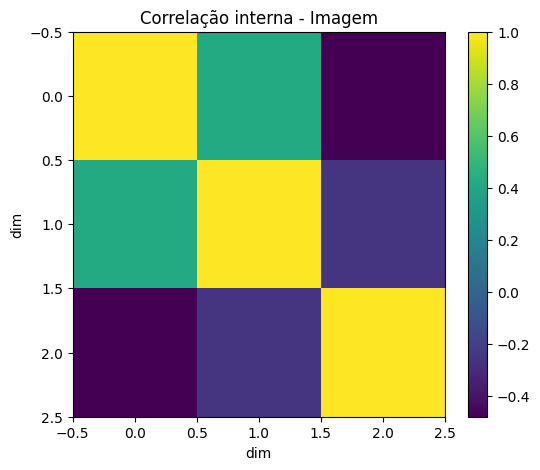

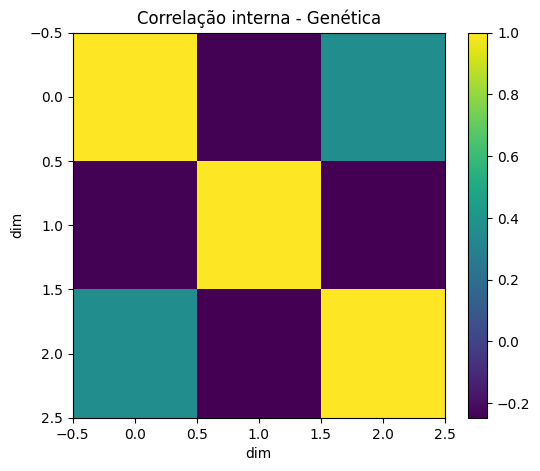

In [9]:
def corr_heatmap(X, title):
    C = np.corrcoef(X, rowvar=False)
    plt.figure(figsize=(6,5))
    plt.imshow(C, aspect="auto")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("dim")
    plt.ylabel("dim")
    plt.show()

corr_heatmap(X_img, "Correlação interna - Imagem")
corr_heatmap(X_gen, "Correlação interna - Genética")


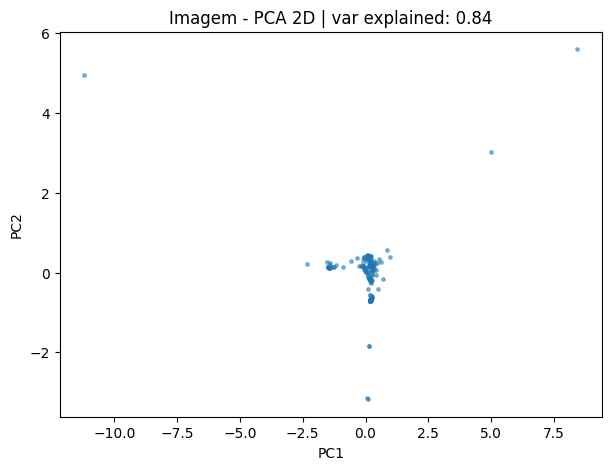

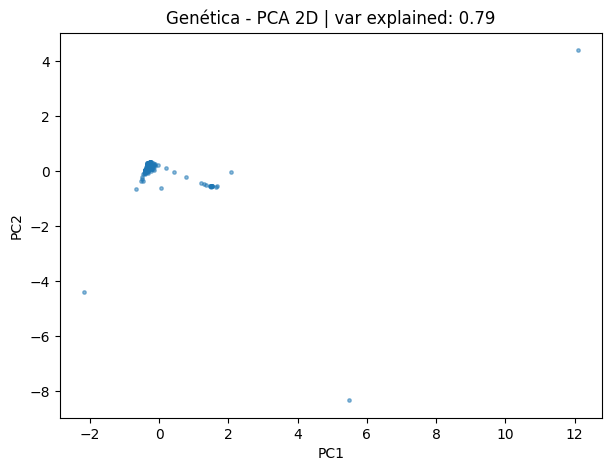

In [10]:
def pca_scatter(X, title):
    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(X)
    plt.figure(figsize=(7,5))
    plt.scatter(Z[:,0], Z[:,1], s=6, alpha=0.5)
    plt.title(title + f" | var explained: {pca.explained_variance_ratio_.sum():.2f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    return Z, pca

Z_img2, pca_img2 = pca_scatter(X_img, "Imagem - PCA 2D")
Z_gen2, pca_gen2 = pca_scatter(X_gen, "Genética - PCA 2D")


Imagem:


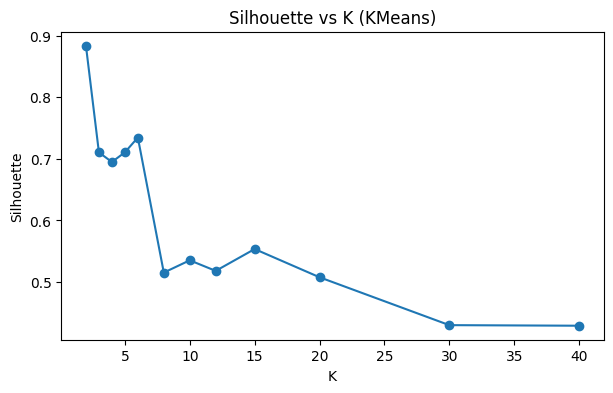

Genética:


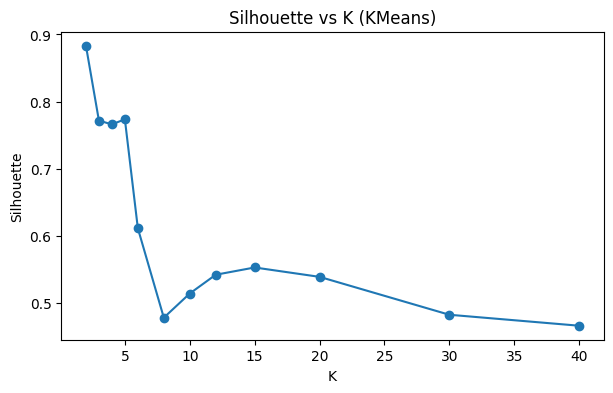

In [11]:
def kmeans_silhouette_curve(X, k_list):
    scores = []
    for k in k_list:
        km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X)
        s = silhouette_score(X, km.labels_)
        scores.append(s)
    plt.figure(figsize=(7,4))
    plt.plot(k_list, scores, marker="o")
    plt.title("Silhouette vs K (KMeans)")
    plt.xlabel("K")
    plt.ylabel("Silhouette")
    plt.show()
    return scores

k_list = [2,3,4,5,6,8,10,12,15,20,30,40]
print("Imagem:")
_ = kmeans_silhouette_curve(X_img, k_list)
print("Genética:")
_ = kmeans_silhouette_curve(X_gen, k_list)


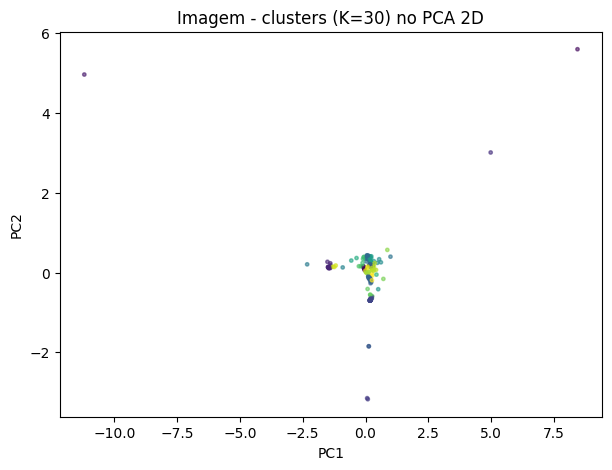

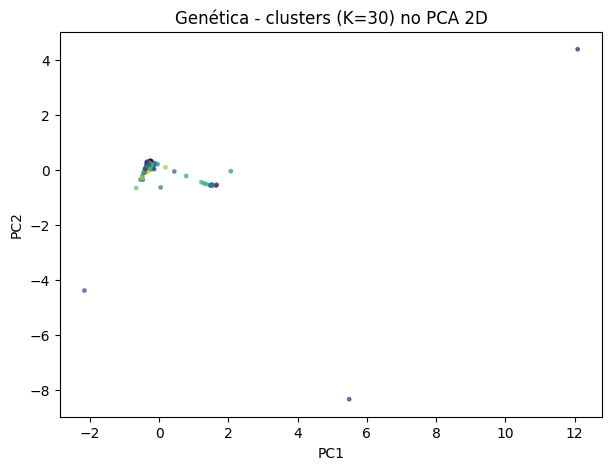

In [12]:
def plot_clusters_2d(Z2, labels, title):
    plt.figure(figsize=(7,5))
    plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=6, alpha=0.6)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

K = 30
km_img = KMeans(n_clusters=K, random_state=42, n_init="auto").fit(X_img)
km_gen = KMeans(n_clusters=K, random_state=42, n_init="auto").fit(X_gen)

plot_clusters_2d(Z_img2, km_img.labels_, f"Imagem - clusters (K={K}) no PCA 2D")
plot_clusters_2d(Z_gen2, km_gen.labels_, f"Genética - clusters (K={K}) no PCA 2D")


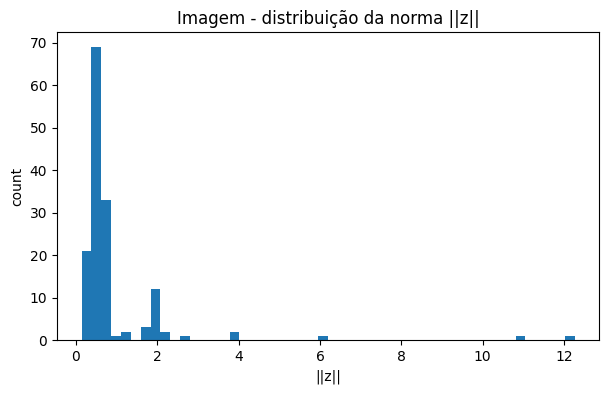

norm stats: count    149.000000
mean       0.930885
std        1.465560
min        0.137788
25%        0.439200
50%        0.529336
75%        0.722188
max       12.265380
dtype: float64


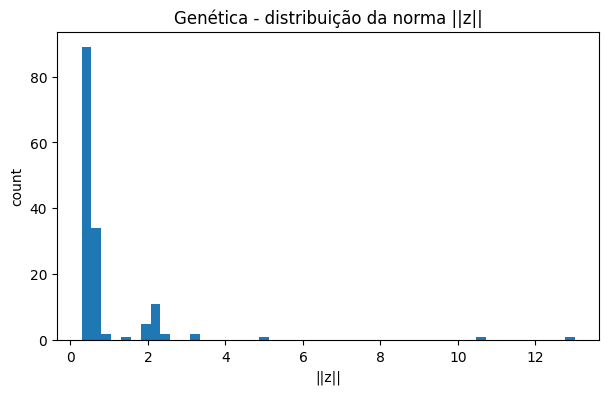

norm stats: count    149.000000
mean       0.915678
std        1.475174
min        0.285728
25%        0.390756
50%        0.423286
75%        0.740049
max       13.015714
dtype: float64


In [13]:
def plot_norms(X, title):
    norms = np.linalg.norm(X, axis=1)
    plt.figure(figsize=(7,4))
    plt.hist(norms, bins=50)
    plt.title(title + " - distribuição da norma ||z||")
    plt.xlabel("||z||")
    plt.ylabel("count")
    plt.show()
    print("norm stats:", pd.Series(norms).describe())

plot_norms(X_img, "Imagem")
plot_norms(X_gen, "Genética")


## B. Integração sem pareamento (cohorts diferentes)

Sem dados pareados, não podemos aplicar CCA por indivíduo nem medir correlação linha-a-linha.

O que dá para fazer (e é defendável):
1) Resumir cada espaço por **protótipos** (clusters KMeans).
2) Encontrar um matching ótimo entre protótipos (Hungarian algorithm).
3) Estimar uma transformação geométrica simples (Procrustes) para alinhar genética → imagem.
4) Avaliar:
   - ganho de similaridade entre protótipos (antes/depois)
   - teste de permutação (significância do alinhamento)
   - visualização em PCA 2D do espaço alinhado


In [14]:
from scipy.optimize import linear_sum_assignment
from scipy.linalg import orthogonal_procrustes

C_img = km_img.cluster_centers_
C_gen = km_gen.cluster_centers_

S_before = cosine_similarity(C_img, C_gen)
row_ind, col_ind = linear_sum_assignment(-S_before)

C_img_m = C_img[row_ind]
C_gen_m = C_gen[col_ind]

sim_match_before = S_before[row_ind, col_ind].mean()
print("similaridade média (protótipos) ANTES:", sim_match_before)

R, _ = orthogonal_procrustes(C_gen_m, C_img_m)

C_gen_aligned = C_gen @ R
S_after = cosine_similarity(C_img, C_gen_aligned)
row2, col2 = linear_sum_assignment(-S_after)
sim_match_after = S_after[row2, col2].mean()

print("similaridade média (protótipos) DEPOIS:", sim_match_after)


similaridade média (protótipos) ANTES: 0.6505349958424869
similaridade média (protótipos) DEPOIS: 0.6423689225856647


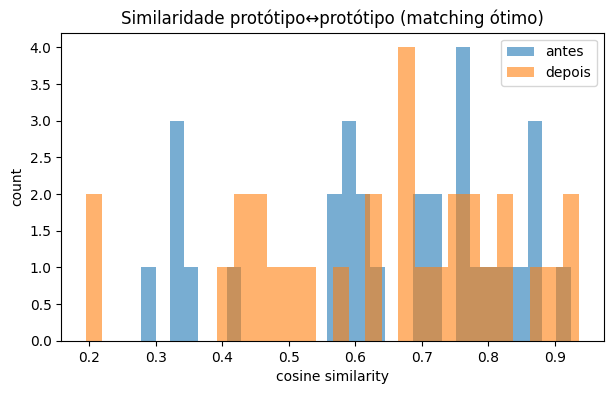

média antes: 0.6505349958424869 média depois: 0.6423689225856647


In [15]:
pairs_before = S_before[row_ind, col_ind]
pairs_after  = S_after[row2, col2]

plt.figure(figsize=(7,4))
plt.hist(pairs_before, bins=30, alpha=0.6, label="antes")
plt.hist(pairs_after,  bins=30, alpha=0.6, label="depois")
plt.title("Similaridade protótipo↔protótipo (matching ótimo)")
plt.xlabel("cosine similarity")
plt.ylabel("count")
plt.legend()
plt.show()

print("média antes:", pairs_before.mean(), "média depois:", pairs_after.mean())


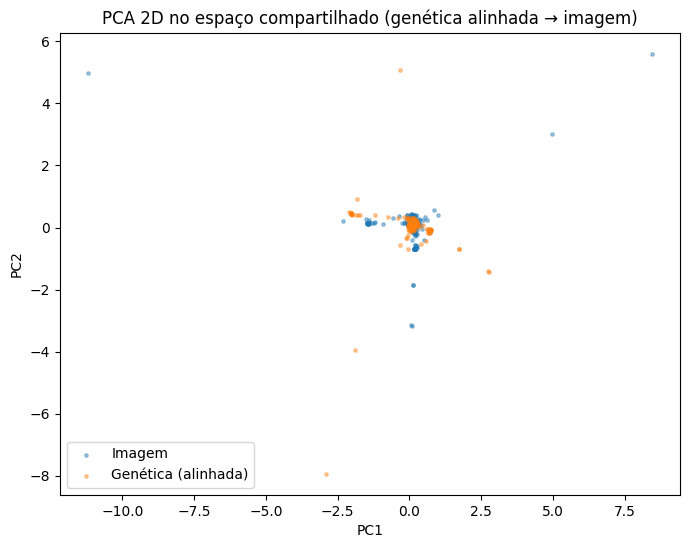

In [17]:
X_gen_aligned = X_gen @ R

# PCA comum (treina na imagem e projeta genética alinhada)
p2 = PCA(n_components=2, random_state=42)
Zi = p2.fit_transform(X_img)
Zg = p2.transform(X_gen_aligned)

plt.figure(figsize=(8,6))
plt.scatter(Zi[:,0], Zi[:,1], s=6, alpha=0.4, label="Imagem")
plt.scatter(Zg[:,0], Zg[:,1], s=6, alpha=0.4, label="Genética (alinhada)")
plt.title("PCA 2D no espaço compartilhado (genética alinhada → imagem)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


## C. O que faríamos com dados pareados (mesmos pacientes)

Se tivéssemos pares (xi_imagem, xi_genética) para o mesmo paciente i, os testes corretos seriam:

### C1) Alinhamento por indivíduo
- CCA / Deep CCA: maximizar correlação entre projeções canônicas.
- Métrica: correlações canônicas (ρ1, ρ2, ...), significância e estabilidade.

### C2) Retrieval cross-modal
- Dado um paciente no domínio imagem, recuperar o paciente correto no domínio genética (top-1 / top-k).
- Métrica: Recall@K, MRR.

### C3) Concordância de risco
- Se existisse um score de risco genético e/ou label clínico:
  - correlação imagem-score_genético
  - classificação (AUC) com modelos multimodais vs unimodais
  - ablação: só imagem, só genética, imagem+genética

### C4) Testes estatísticos
- Permutation test por paciente (embaralhar pareamentos e recalcular métricas)
- Bootstrap para intervalos de confiança


In [18]:
from sklearn.cross_decomposition import CCA

def paired_cca_analysis(X_img_paired, X_gen_paired, n_components=3):
    X_img_p = StandardScaler().fit_transform(X_img_paired)
    X_gen_p = StandardScaler().fit_transform(X_gen_paired)

    cca = CCA(n_components=n_components, max_iter=5000)
    U, V = cca.fit_transform(X_img_p, X_gen_p)

    corrs = [np.corrcoef(U[:,i], V[:,i])[0,1] for i in range(n_components)]
    return corrs, U, V

def cross_modal_retrieval(U, V, k=1):
    # U: pacientes no espaço imagem; V: pacientes no espaço genética
    S = cosine_similarity(U, V)  # [n,n]
    # top-k em cada linha
    topk = np.argsort(-S, axis=1)[:, :k]
    hits = np.mean([i in topk[i] for i in range(S.shape[0])])
    return hits

# Exemplo de uso (quando houver pareamento real):
# corrs, U, V = paired_cca_analysis(X_img_paired, X_gen_paired, n_components=3)
# print("CCA corrs:", corrs)
# print("Retrieval top-1:", cross_modal_retrieval(U, V, k=1))
# print("Retrieval top-5:", cross_modal_retrieval(U, V, k=5))


In [19]:
def make_synthetic_pairs(Xa, Xb, n=2000, noise=0.3, seed=42):
    """
    Demonstração didática:
    cria um pareamento artificial usando uma variável latente comum.
    Não é evidência científica do seu dado real.
    """
    rng = np.random.default_rng(seed)
    na = min(n, Xa.shape[0])
    nb = min(n, Xb.shape[0])

    A = Xa[rng.choice(Xa.shape[0], na, replace=False)]
    B = Xb[rng.choice(Xb.shape[0], nb, replace=False)]

    # cria "score" latente por projeção em vetor aleatório
    w = rng.normal(size=A.shape[1])
    sa = A @ w
    sb = B @ w

    # ordena por score e pareia por rank (didático)
    ia = np.argsort(sa)
    ib = np.argsort(sb)

    m = min(len(ia), len(ib))
    A_pair = A[ia[:m]]
    B_pair = B[ib[:m]] + noise * rng.normal(size=B[ib[:m]].shape)

    return A_pair, B_pair

A_pair, B_pair = make_synthetic_pairs(X_img, X_gen_aligned, n=1500, noise=0.4)

corrs, U, V = paired_cca_analysis(A_pair, B_pair, n_components=min(3, A_pair.shape[1]))
print("CCA corrs (simulado):", corrs)
print("Retrieval top-1 (simulado):", cross_modal_retrieval(U, V, k=1))
print("Retrieval top-5 (simulado):", cross_modal_retrieval(U, V, k=5))


CCA corrs (simulado): [np.float64(0.9105166950844077), np.float64(0.8183999784367829), np.float64(0.21942232507237333)]
Retrieval top-1 (simulado): 0.03355704697986577
Retrieval top-5 (simulado): 0.09395973154362416


# Embeddings de Mamografia (CBIS-DDSM)

Objetivo: gerar um embedding numérico por série (pasta), usando DICOM.

Pipeline:
1) Varre as pastas do CBIS-DDSM
2) Encontra todos os .dcm (normalmente 1 por "full mammogram images")
3) Lê DICOM (aplica VOI LUT, corrige MONOCHROME1)
4) Pré-processa (resize 224, normaliza, 3 canais)
5) Extrai embedding via CNN pré-treinada (ResNet50 por padrão)
6) Agrega por série (média)
7) Salva:
   - mammo_embeddings.pkl (vetores)
   - mammo_metadata.csv (metadados)


import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models


In [20]:
import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models


In [21]:
CBIS_ROOT = Path("images_dataset/manifest/CBIS-DDSM")  # <-- ajuste se necessário
assert CBIS_ROOT.exists(), f"Não achei {CBIS_ROOT}"

OUT_DIR = Path("./outputs_mammo")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("CBIS_ROOT:", CBIS_ROOT)


CBIS_ROOT: images_dataset\manifest\CBIS-DDSM


In [22]:
import re

def parse_folder_name(name: str):
    """
    Exemplo:
      Calc-Test_P_00038_LEFT_CC
      Calc-Training_P_00302_RIGHT_MLO_1
    """
    m = re.match(r"^(Calc|Mass)-(Test|Training)_P_(\d+)_([A-Z]+)_(CC|MLO)(?:_(\d+))?$", name)
    if not m:
        return None
    lesion = m.group(1).lower()      # calc / mass
    split  = m.group(2).lower()      # test / training
    patient = m.group(3)             # 00038
    side   = m.group(4).lower()      # left / right
    view   = m.group(5).lower()      # cc / mlo
    suffix = m.group(6)              # 1,2,... or None
    return dict(
        lesion=lesion,
        split=split,
        patient=patient,
        side=side,
        view=view,
        suffix=suffix
    )


In [24]:
folders = [p for p in CBIS_ROOT.iterdir() if p.is_dir()]
records = []

for folder in folders:
    info = parse_folder_name(folder.name)
    if info is None:
        continue
    records.append({
        "join_id": folder.name,   # ID da série (único no seu cenário)
        "patient_id": f"P_{info['patient']}",
        "split": info["split"],
        "lesion_type": info["lesion"],
        "laterality": info["side"],
        "view": info["view"],
        "series_variant": info["suffix"] if info["suffix"] else "0",
        "folder_path": str(folder)
    })

fs_df = pd.DataFrame(records)
print("fs_df:", fs_df.shape)
fs_df.head()


fs_df: (6671, 8)


,join_id,patient_id,split,lesion_type,laterality,view,series_variant,folder_path
0,Calc-Test_P_00038_LEFT_CC,P_00038,test,calc,left,cc,0,images_dataset\manifest\CBIS-DDSM\Calc-Test_P_...
1,Calc-Test_P_00038_LEFT_CC_1,P_00038,test,calc,left,cc,1,images_dataset\manifest\CBIS-DDSM\Calc-Test_P_...
2,Calc-Test_P_00038_LEFT_MLO,P_00038,test,calc,left,mlo,0,images_dataset\manifest\CBIS-DDSM\Calc-Test_P_...
3,Calc-Test_P_00038_LEFT_MLO_1,P_00038,test,calc,left,mlo,1,images_dataset\manifest\CBIS-DDSM\Calc-Test_P_...
4,Calc-Test_P_00038_RIGHT_CC,P_00038,test,calc,right,cc,0,images_dataset\manifest\CBIS-DDSM\Calc-Test_P_...


In [25]:
def find_dicom_files(series_folder: Path):
    # pega todos os .dcm em qualquer subpasta
    return sorted(series_folder.rglob("*.dcm"))

# cria coluna com lista de dicoms
dicom_lists = []
for fp in tqdm(fs_df["folder_path"].tolist()):
    dlist = find_dicom_files(Path(fp))
    dicom_lists.append(dlist)

fs_df["dicom_files"] = dicom_lists
fs_df["n_dicoms"] = fs_df["dicom_files"].apply(len)

print(fs_df["n_dicoms"].describe())
fs_df.head()


100%|████████████████████████████████████████████████████████████████████████████| 6671/6671 [00:03<00:00, 1798.77it/s]

count    6671.000000
mean        1.534852
std         0.498821
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: n_dicoms, dtype: float64


,join_id,patient_id,split,lesion_type,laterality,view,series_variant,folder_path,dicom_files,n_dicoms
0,Calc-Test_P_00038_LEFT_CC,P_00038,test,calc,left,cc,0,images_dataset\manifest\CBIS-DDSM\Calc-Test_P_...,[images_dataset\manifest\CBIS-DDSM\Calc-Test_P...,1
1,Calc-Test_P_00038_LEFT_CC_1,P_00038,test,calc,left,cc,1,images_dataset\manifest\CBIS-DDSM\Calc-Test_P_...,[images_dataset\manifest\CBIS-DDSM\Calc-Test_P...,2
2,Calc-Test_P_00038_LEFT_MLO,P_00038,test,calc,left,mlo,0,images_dataset\manifest\CBIS-DDSM\Calc-Test_P_...,[images_dataset\manifest\CBIS-DDSM\Calc-Test_P...,1
3,Calc-Test_P_00038_LEFT_MLO_1,P_00038,test,calc,left,mlo,1,images_dataset\manifest\CBIS-DDSM\Calc-Test_P_...,[images_dataset\manifest\CBIS-DDSM\Calc-Test_P...,2
4,Calc-Test_P_00038_RIGHT_CC,P_00038,test,calc,right,cc,0,images_dataset\manifest\CBIS-DDSM\Calc-Test_P_...,[images_dataset\manifest\CBIS-DDSM\Calc-Test_P...,1


In [27]:
fs_df = fs_df[fs_df["n_dicoms"] > 0].reset_index(drop=True)
print("Depois do filtro:", fs_df.shape)


Depois do filtro: (6671, 10)


In [28]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

def load_dicom_image(dcm_path: Path) -> np.ndarray:
    """
    Retorna imagem float32 normalizada [0,1] (aprox).
    """
    ds = pydicom.dcmread(str(dcm_path))
    arr = ds.pixel_array

    # aplica VOI LUT se existir (melhor contraste)
    try:
        arr = apply_voi_lut(arr, ds)
    except Exception:
        pass

    arr = arr.astype(np.float32)

    # rescale slope/intercept
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    inter = float(getattr(ds, "RescaleIntercept", 0.0))
    arr = arr * slope + inter

    # MONOCHROME1 precisa inverter
    photometric = getattr(ds, "PhotometricInterpretation", "").upper()
    if photometric == "MONOCHROME1":
        arr = arr.max() - arr

    # normaliza robusto por percentis (evita extremos)
    lo, hi = np.percentile(arr, [1, 99])
    arr = np.clip(arr, lo, hi)
    arr = (arr - lo) / (hi - lo + 1e-6)

    return arr


In [29]:
test_row = fs_df.iloc[0]
test_dcm = test_row["dicom_files"][0]
img = load_dicom_image(test_dcm)
print(img.shape, img.dtype, img.min(), img.max())


(4616, 3016) float64 0.0 0.9999999999660292


In [31]:
def preprocess_image_np_to_tensor(img_np: np.ndarray, size=224) -> torch.Tensor:
    """
    img_np: HxW float32 em [0,1]
    retorna tensor float32 [3,size,size]
    """
    x = torch.tensor(img_np, dtype=torch.float32)      # [H,W]
    x = x.unsqueeze(0).unsqueeze(0)                    # [1,1,H,W]
    x = F.interpolate(x, size=(size, size), mode="bilinear", align_corners=False)
    x = x.squeeze(0)                                   # [1,size,size]
    x = x.repeat(3, 1, 1)                              # [3,size,size]
    return x



In [32]:
x = preprocess_image_np_to_tensor(img, size=224)
print(x.shape, x.dtype, x.min().item(), x.max().item())


torch.Size([3, 224, 224]) torch.float32 0.0 1.0


In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

def build_backbone(name="resnet50"):
    if name == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        backbone = nn.Sequential(*(list(m.children())[:-1]))  # remove FC -> [B,2048,1,1]
        out_dim = 2048
    elif name == "densenet121":
        m = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        backbone = m.features
        out_dim = 1024
    else:
        raise ValueError("backbone not supported")

    return backbone, out_dim

backbone, emb_dim = build_backbone("resnet50")
backbone = backbone.to(device).eval()

print("emb_dim:", emb_dim)


device: cpu
emb_dim: 2048


In [34]:
class MammoSeriesDataset(Dataset):
    def __init__(self, df: pd.DataFrame, max_images_per_series=1, image_size=224):
        self.df = df.reset_index(drop=True)
        self.max_images = max_images_per_series
        self.image_size = image_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dcm_files = row["dicom_files"]

        # escolhe até N dicoms (normalmente 1 já basta)
        dcm_files = dcm_files[: self.max_images]

        xs = []
        for dcm in dcm_files:
            try:
                img_np = load_dicom_image(dcm)
                x = preprocess_image_np_to_tensor(img_np, size=self.image_size)  # [3,224,224]
                xs.append(x)
            except Exception as e:
                continue

        if len(xs) == 0:
            return None

        xstack = torch.stack(xs, dim=0)  # [n,3,224,224]

        meta = {
            "join_id": row["join_id"],
            "patient_id": row["patient_id"],
            "split": row["split"],
            "lesion_type": row["lesion_type"],
            "laterality": row["laterality"],
            "view": row["view"],
            "series_variant": row["series_variant"],
            "n_dicoms": row["n_dicoms"],
        }
        return xstack, meta

def collate_skip_none(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    xs, metas = zip(*batch)
    return xs, metas


In [35]:
@torch.no_grad()
def embed_batch_series(xstack_list):
    """
    xstack_list: lista de tensores [n_i,3,224,224] (um por série no batch)
    Retorna lista de embeddings numpy (um por série).
    """
    outs = []
    for xstack in xstack_list:
        xstack = xstack.to(device)          # [n,3,224,224]
        feats = backbone(xstack)            # [n,2048,1,1]
        feats = feats.squeeze(-1).squeeze(-1)  # [n,2048]
        emb = feats.mean(dim=0)             # [2048] agregação por série
        outs.append(emb.detach().cpu().numpy())
    return outs


In [36]:
dataset = MammoSeriesDataset(fs_df, max_images_per_series=1, image_size=224)
loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_skip_none)

embeddings = []
metas_out = []

for batch in tqdm(loader, total=len(loader)):
    if batch is None:
        continue
    xs_list, metas = batch
    embs = embed_batch_series(xs_list)
    embeddings.extend(embs)
    metas_out.extend(list(metas))

print("Embeddings:", len(embeddings), "dim:", embeddings[0].shape if embeddings else None)
print("Metas:", len(metas_out))


100%|████████████████████████████████████████████████████████████████████████████████| 834/834 [29:29<00:00,  2.12s/it]

Embeddings: 6671 dim: (2048,)
Metas: 6671


In [ ]:
emb_arr = np.vstack(embeddings)  # [N, 2048]
meta_df = pd.DataFrame(metas_out)

with open(OUT_DIR / "mammo_embeddings.pkl", "wb") as f:
    pickle.dump({"embeddings": emb_arr, "meta": meta_df}, f)

meta_df.to_csv(OUT_DIR / "mammo_metadata.csv", index=False)
np.save(OUT_DIR / "mammo_embeddings.npy", emb_arr)

print("Saved:", OUT_DIR / "mammo_embeddings.pkl")
print("Saved:", OUT_DIR / "mammo_metadata.csv")
print("Saved:", OUT_DIR / "mammo_embeddings.npy")


In [ ]:
from sklearn.preprocessing import StandardScaler

E = StandardScaler().fit_transform(emb_arr)

# norma
norms = np.linalg.norm(E, axis=1)
plt.figure(figsize=(7,4))
plt.hist(norms, bins=50)
plt.title("Embeddings (imagem) - distribuição da norma ||e||")
plt.xlabel("||e||")
plt.ylabel("count")
plt.show()

# PCA 2D
p2 = PCA(n_components=2, random_state=42)
Z = p2.fit_transform(E)

plt.figure(figsize=(7,5))
plt.scatter(Z[:,0], Z[:,1], s=6, alpha=0.5)
plt.title(f"Embeddings (imagem) PCA2 | var={p2.explained_variance_ratio_.sum():.2f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

E = StandardScaler().fit_transform(emb_arr)

# norma
norms = np.linalg.norm(E, axis=1)
plt.figure(figsize=(7,4))
plt.hist(norms, bins=50)
plt.title("Embeddings (imagem) - distribuição da norma ||e||")
plt.xlabel("||e||")
plt.ylabel("count")
plt.show()

# PCA 2D
p2 = PCA(n_components=2, random_state=42)
Z = p2.fit_transform(E)

plt.figure(figsize=(7,5))
plt.scatter(Z[:,0], Z[:,1], s=6, alpha=0.5)
plt.title(f"Embeddings (imagem) PCA2 | var={p2.explained_variance_ratio_.sum():.2f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
